In [230]:
!pip3 install saxpy

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
import nltk
from nltk import bigrams
from nltk import trigrams
from saxpy.sax import sax_via_window
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [36]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [37]:
def discretize(original_signal, paa_size=6, window_size=2, amount_of_levels=3):
    sax1 = sax_via_window(original_signal, window_size, paa_size, amount_of_levels)
    indices = []
    for k, v in sax1.items():
        indices.extend(v)
    indices.sort()
    discrete_signal = pd.DataFrame(index=indices, columns=["word"])
    for k, v in sax1.items():
        discrete_signal.loc[v] = k
    return discrete_signal

In [38]:
def get_trigram(discrete_signal):
    ts_string = " ".join(discrete_signal['word'])
    tokens = nltk.word_tokenize(ts_string)
    tri_tokens = trigrams(tokens)
    tri_list = [tuple(trigram) for trigram in tri_tokens]
    fdist = nltk.FreqDist(tri_list)
    trigram_df = pd.DataFrame.from_dict(fdist,orient='index')
    trigram_df_prob = trigram_df/trigram_df.sum()
    return pd.Series(tri_list, index=discrete_signal.index[:-2]), trigram_df_prob[0]

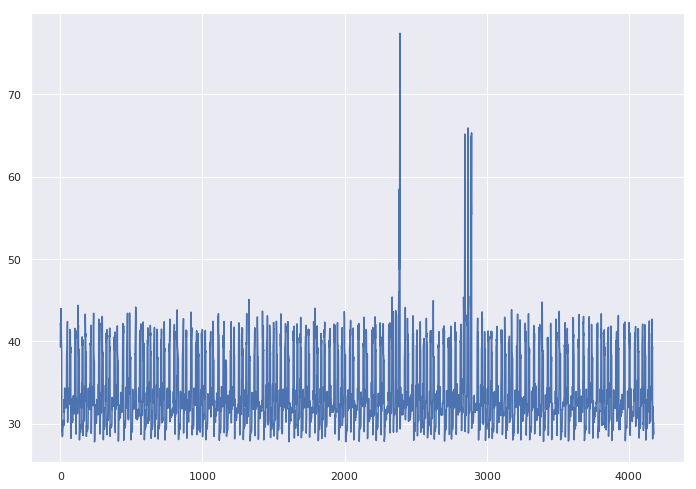

In [39]:
sns.lineplot(data=df2['P_J14'])

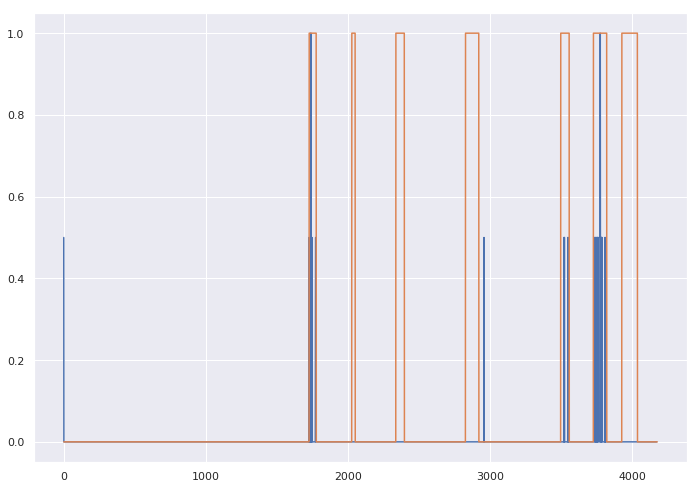

In [60]:
## Select a target, discretize and see if it overlaps
target_columns = ['F_PU6', 'S_PU6', 'F_PU11', 'S_PU11', 'F_PU7', 'S_PU7', 'L_T1', 'P_J14', 'P_J302', 'P_J307']
fig, ax = plt.subplots()

alert_sum = []

paa_size=3
window_size=2
amount_of_levels=3

for target in target_columns:
    dat1 = df1[target].values
    tris, triprob = get_trigram(discretize(dat1,paa_size,window_size,amount_of_levels))

    dat2 = df2[target].values
    tris2, tris2prob = get_trigram(discretize(dat2,paa_size,window_size,amount_of_levels))

    threshold = 0
    if len(alert_sum) == 0:
        results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
        alert_sum = results
    else:
        results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
        alert_sum = alert_sum.add(results, fill_value=0)

    
sns.lineplot(data=alert_sum/max(alert_sum), ax=ax)
sns.lineplot(data=df2['ATT_FLAG'], ax=ax)

In [53]:
## Count the occurences of different words
word_counts = discrete_signal['word'].value_counts()

NameError: name 'discrete_signal' is not defined

In [54]:
## Show example:
lent = 5
print(discrete_signal[0:lent])
plot = sns.lineplot(data=dat[0:lent])
plot.set(xlim = (0,lent));
plot.set_title("Occurences of word parts of {}".format("".join(discrete_signal[0:lent])));
plot.set_ylabel("Occurence");
plot.set_xlabel("Word parts");

NameError: name 'discrete_signal' is not defined

In [89]:
## Create a string out of it:
ts_string = " ".join(discrete_signal['word'])

In [56]:
## Creating tokens and do n-gram stuff

tokens = nltk.word_tokenize(ts_string)
bi_tokens = bigrams(tokens)
tri_tokens = trigrams(tokens)
fdist = nltk.FreqDist(tri_tokens)
trigram_df = pd.DataFrame.from_dict(fdist,orient='index')

NameError: name 'ts_string' is not defined

In [57]:
trigram_df_prob.loc[[('aabc', 'aacc', 'abcc')], 0]

NameError: name 'trigram_df_prob' is not defined

In [58]:
trigram_df_prob = trigram_df/trigram_df.sum()

fig = plt.figure()
ax = fig.add_subplot(111)
#arbitrary threshold value
threshold= min(trigram_df_prob)
ax.axhline(y=threshold, label='Threshold',color="r")
ax.plot(trigram_df_prob.reset_index(drop=True), label = "Trigram probabilities")
ax.set_title('Trigram probabilities')
ax.set_xlabel('Trigrams')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

NameError: name 'trigram_df' is not defined

In [96]:
data = df1.drop("DATETIME",1)
x = []
x = pd.DataFrame(x)
for index in range(0,len(data.columns)):
    indexname = "{}".format(data.columns[index])
    dat = data[indexname].values
    amount_of_levels = 3
    window_size = 2

    discrete_signal = []
    for t in range(len(dat)-window_size):
        dat_znorm = znorm(dat[t:t+window_size])
        discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))

    x[indexname] = discrete_signal
ngrams = x    



KeyboardInterrupt: 

In [ ]:
test = list(ngrams["L_T1"].iloc[:3])
test = "".join(test)
trigram_df_prob_lt1 = trigram_df_prob.sort_values(0,ascending=False)


In [ ]:
indices = []
for index in range(0,len(trigram_df_prob)):   
    indices.append("".join(trigram_df_prob.index[index]))

In [ ]:
indices = pd.Series(indices)
trigram_df_prob = trigram_df_prob.set_index(indices)
trigram_df_prob.loc[test]

In [ ]:
ngrams.head()